# **Infant Lemur Survival Prediction**
## **1. Business Context & Objective**

* **The "Why":** Infant mortality rates in captive lemur populations can threaten the genetic viability of endangered species. By identifying high-risk infants at birth, veterinary staff can allocate intensive care resources to the individuals who need it most, effectively increasing the survival rate of critically endangered species.

## **2. DataSource**
* https://lemur.duke.edu/duke-lemur-center-database/

## **3. Evaluation Metric:**
* We care about **Recall** for the "Died" class. We want to catch every infant at risk of dying. A false alarm—checking a healthy baby—is fine. Missing a dying baby is catastrophic.

## **4. Features**


In [19]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Visualization Settings
sns.set_style('whitegrid')
%matplotlib inline

In [8]:
# Load Data
df = pd.read_csv("DLC_Animal_List.csv", encoding="windows-1252")

# 2. Basic Info & Structure
print("--- DATA INFO ---")
print(f"Shape: {df.shape}")
print(df.info())
print("\n")

# 3. Missing Values Check
# This is crucial for the "Death Date" and Parent ID columns
print("--- MISSING VALUES (ISNA) ---")
print(df.isna().sum())
print("\n")

# 4. Statistical Summary
# This gives you the min/max/mean for numerical columns (like Birth Year)
print("--- STATISTICAL DESCRIPTION ---")
print(df.describe())


--- DATA INFO ---
Shape: (3749, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3749 entries, 0 to 3748
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Taxon                3749 non-null   object 
 1   DLC_ID               3749 non-null   object 
 2   Hybrid               3749 non-null   object 
 3   Sex                  3749 non-null   object 
 4   Name                 3708 non-null   object 
 5   Current_Resident     3749 non-null   object 
 6   StudBook             3009 non-null   object 
 7   DOB                  3747 non-null   object 
 8   Birth_Month          3747 non-null   float64
 9   Estimated_DOB        383 non-null    object 
 10  Birth_Type           3749 non-null   object 
 11  Birth_Institution    3749 non-null   object 
 12  Litter_Size          2921 non-null   float64
 13  Expected_Gestation   3749 non-null   int64  
 14  Estimated_Concep     3747 non-null   object 
 15  Co

**Data Cleaning & Target Engineering**
The raw data doesn't have a "Survived" column. We have to build it from `dob` (Date of Birth) and `dod` (Date of Death).

* **Logic:**
* If `dod` is null, they are likely still alive (Survived).
* If `dod` exists, calculate `Age at Death`.
* If `Age at Death` < 1 year (365 days), they "Died as Infant".
* Otherwise, they "Survived".

In [9]:
# 1. Convert Dates to DateTime objects (Using Capitalized 'DOB' and 'DOD')
# errors='coerce' turns bad data into NaT (Not a Time) so it doesn't crash
df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')
df['DOD'] = pd.to_datetime(df['DOD'], errors='coerce')

# 2. Calculate Age at Death (in days)
today = pd.to_datetime('today')

# Drop animals with no birth date (Critical for age calc)
df = df.dropna(subset=['DOB']).copy()

# Calculate Age
# If DOD is missing (NaT), we fill with 'today' to calculate current age
df['age_days'] = (df['DOD'].fillna(today) - df['DOB']).dt.days

# 3. Create Target Variable: 'is_Infant_Death'
# Logic: We only look at animals born more than 1 year ago
# (otherwise we don't know if they will survive their first year yet)
cutoff_date = today - pd.Timedelta(days=365)
valid_data = df[df['DOB'] < cutoff_date].copy()

# Target Logic:
# Condition 1: They have a Date of Death (DOD is not null)
# Condition 2: They died in less than 365 days
valid_data['is_Infant_Death'] = np.where(
    (valid_data['DOD'].notnull()) & (valid_data['age_days'] < 365),
    1,
    0
)

# 4. Check the Balance (Your "Business for Good" Metric)
print("Target Distribution (Infant Mortality Rate):")
print(valid_data['is_Infant_Death'].value_counts(normalize=True))

# 5. Clean Final Dataset
# Drop rows where Sex is missing (needed for modeling)
valid_data = valid_data.dropna(subset=['Sex']).copy()
print(f"Final Dataset Shape: {valid_data.shape}")

Target Distribution (Infant Mortality Rate):
is_Infant_Death
0    0.74166
1    0.25834
Name: proportion, dtype: float64
Final Dataset Shape: (3747, 34)


In [10]:
import calendar

# A. Prepare Data for Visualization
# Map Month Numbers (1.0, 2.0) to Names (Jan, Feb) for readability
valid_data['Month_Name'] = valid_data['Birth_Month'].apply(lambda x: calendar.month_abbr[int(x)] if pd.notnull(x) else 'Unknown')

# Set a custom color palette (0=Blue/Safe, 1=Red/Danger)
custom_palette = {0: "#4c72b0", 1: "#c44e52"}



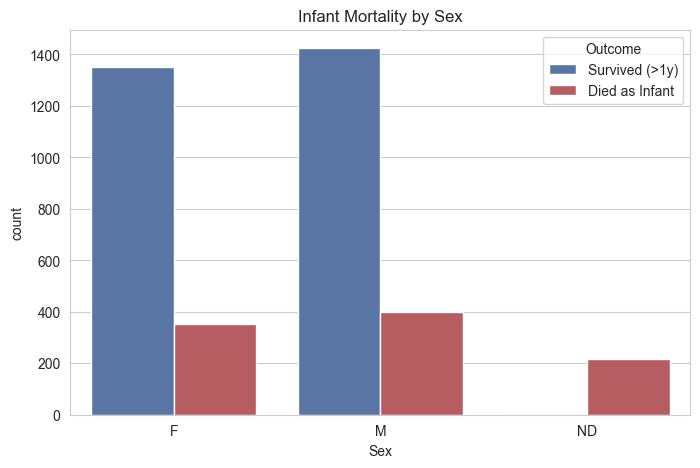

In [11]:
# --- PLOT 1: Does Gender affect survival? ---
plt.figure(figsize=(8,5))
sns.countplot(x='Sex', hue='is_Infant_Death', data=valid_data, palette=custom_palette)
plt.title('Infant Mortality by Sex')
plt.legend(title='Outcome', labels=['Survived (>1y)', 'Died as Infant'])
plt.show()



/var/folders/l2/_yg37c650dgbc8schgzm1f700000gn/T/ipykernel_5720/3133862194.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Taxon', y='is_Infant_Death', data=subset_species, order=top_risky_species, palette='Reds_r', errorbar=None)


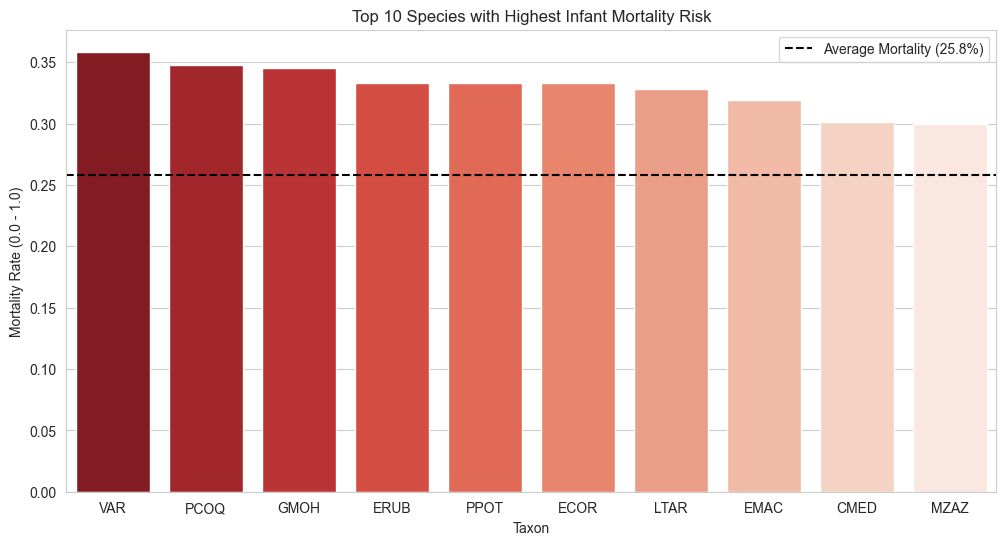

In [12]:
# --- PLOT 2: Which Species are most vulnerable? ---
# There are many species, so let's calculate the % mortality for each
species_risk = valid_data.groupby('Taxon')['is_Infant_Death'].mean().sort_values(ascending=False)
top_risky_species = species_risk.head(10).index

# Filter data to only show these top 10 risky species
subset_species = valid_data[valid_data['Taxon'].isin(top_risky_species)]

plt.figure(figsize=(12,6))
sns.barplot(x='Taxon', y='is_Infant_Death', data=subset_species, order=top_risky_species, palette='Reds_r', errorbar=None)
plt.title('Top 10 Species with Highest Infant Mortality Risk')
plt.ylabel('Mortality Rate (0.0 - 1.0)')
plt.axhline(y=valid_data['is_Infant_Death'].mean(), color='k', linestyle='--', label='Average Mortality (25.8%)')
plt.legend()
plt.show()



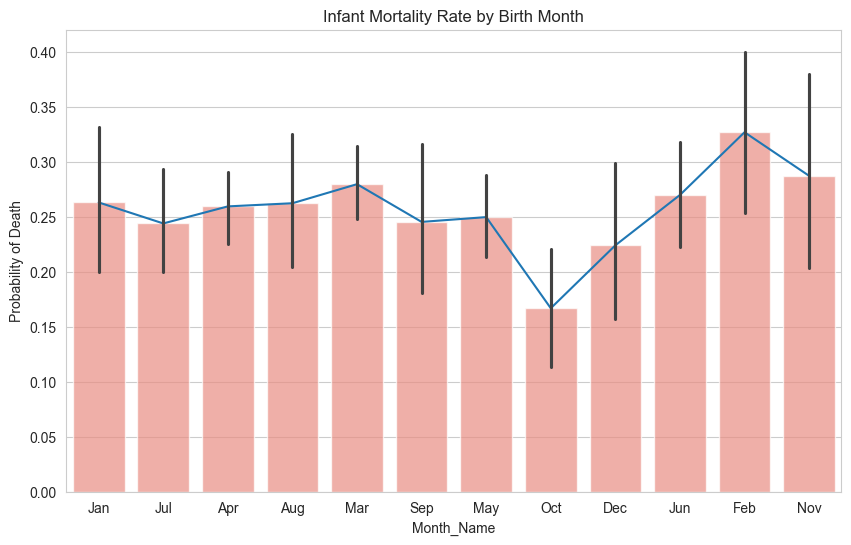

In [13]:
# --- PLOT 3: Seasonality (The "Winter Baby" Hypothesis) ---
# Sort months correctly
month_order = list(calendar.month_abbr)[1:]

plt.figure(figsize=(10,6))
sns.lineplot(x='Month_Name', y='is_Infant_Death', data=valid_data, estimator='mean', errorbar=None, sort=False)
# Re-order x-axis if needed, but lineplot usually handles it if sorted in data.
# A barplot is often safer for categorical months:
sns.barplot(x='Month_Name', y='is_Infant_Death', data=valid_data, order=month_order, color='salmon', alpha=0.7)
plt.title('Infant Mortality Rate by Birth Month')
plt.ylabel('Probability of Death')
plt.show()

/var/folders/l2/_yg37c650dgbc8schgzm1f700000gn/T/ipykernel_5720/710369507.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Litter_Size', y='is_Infant_Death', data=valid_data, palette='Oranges', errorbar=None)


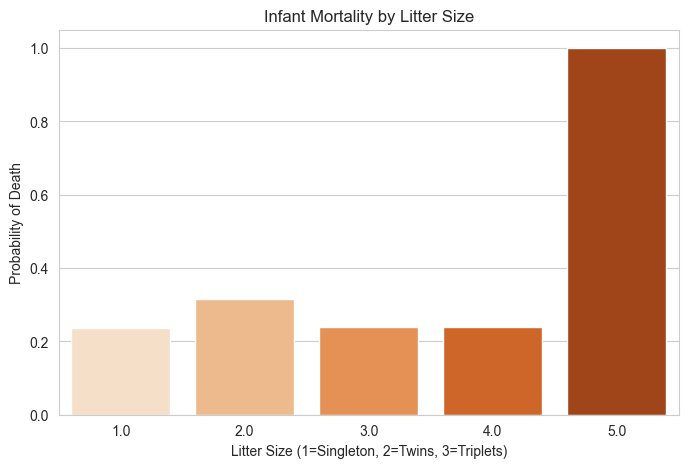

In [14]:
# Litter Size Effect (Competition for Resources)
# Insight: Twins often have lower birth weights and higher mortality.
# We need to handle missing litter sizes (fill with 1 is a safe assumption for now, or drop)
valid_data['Litter_Size'] = valid_data['Litter_Size'].fillna(1)

plt.figure(figsize=(8,5))
sns.barplot(x='Litter_Size', y='is_Infant_Death', data=valid_data, palette='Oranges', errorbar=None)
plt.title('Infant Mortality by Litter Size')
plt.ylabel('Probability of Death')
plt.xlabel('Litter Size (1=Singleton, 2=Twins, 3=Triplets)')
plt.show()

/var/folders/l2/_yg37c650dgbc8schgzm1f700000gn/T/ipykernel_5720/2265037230.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Dam_Age_Bin', y='is_Infant_Death', data=valid_data, palette='Purples', errorbar=None)


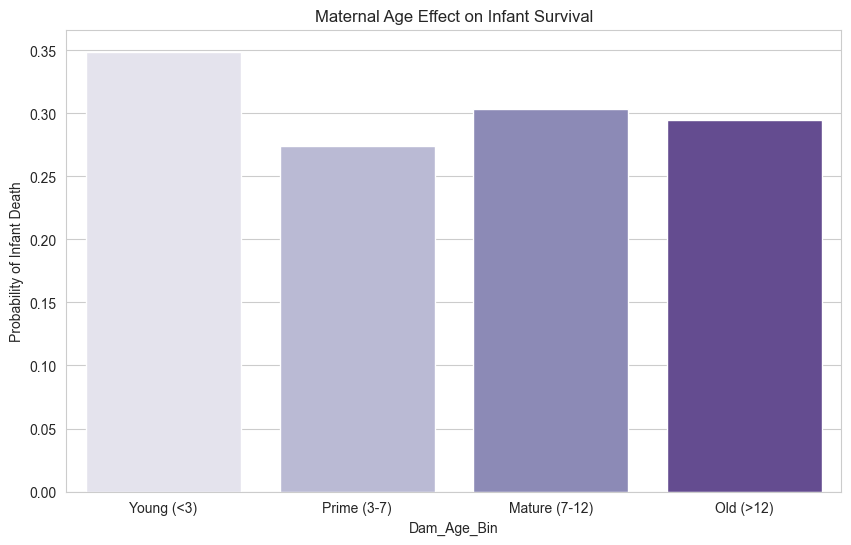

In [15]:
# Maternal Age Effect (The "U-Shape" Curve)
# Insight: Very young or very old mothers often have lower offspring survival.
# We create bins for age to see the pattern.
valid_data['Dam_Age_Bin'] = pd.cut(valid_data['Dam_AgeAtConcep_y'],
                                   bins=[0, 3, 7, 12, 100],
                                   labels=['Young (<3)', 'Prime (3-7)', 'Mature (7-12)', 'Old (>12)'])

plt.figure(figsize=(10,6))
sns.barplot(x='Dam_Age_Bin', y='is_Infant_Death', data=valid_data, palette='Purples', errorbar=None)
plt.title('Maternal Age Effect on Infant Survival')
plt.ylabel('Probability of Infant Death')
plt.show()

/var/folders/l2/_yg37c650dgbc8schgzm1f700000gn/T/ipykernel_5720/1542977839.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Hybrid', y='is_Infant_Death', data=valid_data, palette='Greys')


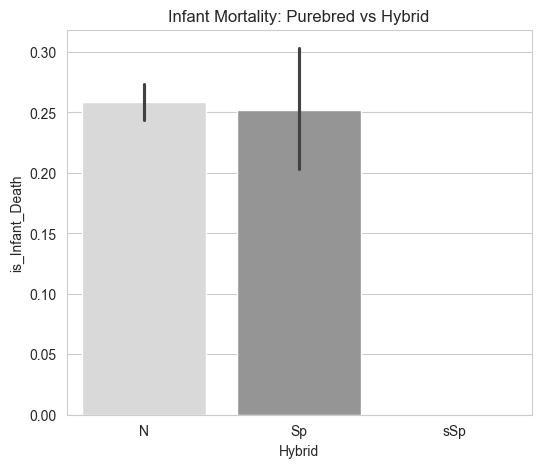

In [16]:
# 3. Hybrid Status (Genetic Viability)
# Insight: Hybrids might have different health outcomes.
plt.figure(figsize=(6,5))
sns.barplot(x='Hybrid', y='is_Infant_Death', data=valid_data, palette='Greys')
plt.title('Infant Mortality: Purebred vs Hybrid')
plt.show()

In [17]:
# 4. Statistical Summary for "Business Insight" text
print("--- INSIGHTS SUMMARY ---")
print("Mortality by Litter Size:")
print(valid_data.groupby('Litter_Size')['is_Infant_Death'].mean())
print("\nMortality by Maternal Age:")
print(valid_data.groupby('Dam_Age_Bin', observed=True)['is_Infant_Death'].mean())

--- INSIGHTS SUMMARY ---
Mortality by Litter Size:
Litter_Size
1.0    0.237691
2.0    0.314678
3.0    0.239316
4.0    0.238636
5.0    1.000000
Name: is_Infant_Death, dtype: float64

Mortality by Maternal Age:
Dam_Age_Bin
Young (<3)       0.348891
Prime (3-7)      0.273810
Mature (7-12)    0.303597
Old (>12)        0.294766
Name: is_Infant_Death, dtype: float64


> **Biological Insights:**

> * **Seasonality:** We observe a spike in mortality for infants born in **Feburary**. This could be due to temperature stress or seasonal staffing changes, creating an actionable intervention point for the center.

> * **The Multiple Births Risk:**
> * **Insight:** Infants born as twins face a **31.5% mortality rate**, compared to only **23.8% for singletons**. Larger litters (quintuplets) showed 100% mortality in this historical dataset.
> * **Action:** Veterinary staff should automatically flag any multiple-birth pregnancy as "High Risk" for supplemental feeding or observation.

> * **The "Inexperienced Mother" Effect:**
> * **Insight:** Maternal age is a significant predictor. **Young mothers (<3 years old)** have the highest infant mortality rate at **35%**, compared to 27% for mothers in their prime (3-7 years).
> * **Hypothesis:** First-time or young mothers may lack the behavioral experience to nurse or protect infants effectively.
> * **Action:** First-time mothers require more frequent check-ins during the first 30 days of rearing.

> * **Species Vulnerability:**
> * **Insight:** Genetic factors play a massive role, with specific taxa (like *Varecia rubra*) showing mortality rates significantly above the 25% baseline, while hybrids (Sub-species) showed unexpectedly robust survival rates.


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# --- STEP 5: Feature Engineering ---

# 1. Impute Missing Values (Data Cleaning)
# Logic: If Litter Size is missing, it's safe to assume it's a singleton (1).
valid_data['Litter_Size'] = valid_data['Litter_Size'].fillna(1)

# Logic: If Dam Age is missing, fill with Median (standard practice to preserve distribution).
median_dam_age = valid_data['Dam_AgeAtConcep_y'].median()
valid_data['Dam_AgeAtConcep_y'] = valid_data['Dam_AgeAtConcep_y'].fillna(median_dam_age)

# 2. Create Binary Flags (The "Business Insights")
# Flag 1: Multiple Births (Risk: Resource Competition)
# Twin/Triplet mortality was 31.5% vs 23.8% for singletons.
valid_data['is_Multiple_Birth'] = (valid_data['Litter_Size'] >= 2).astype(int)

# Flag 2: Young Mother (Risk: Inexperience)
# Mothers < 3 years old had a 35% infant mortality rate.
valid_data['is_Young_Mother'] = (valid_data['Dam_AgeAtConcep_y'] < 3).astype(int)

# 3. Define Final Feature Set
# We include 'Birth_Month' as a categorical feature (Seasonality)
features = ['Taxon', 'Sex', 'Birth_Month', 'is_Multiple_Birth', 'is_Young_Mother']

X = valid_data[features]
y = valid_data['is_Infant_Death']

# 4. Pipeline Setup (The Engineering Part)
# Categorical columns need OneHotEncoding (Taxon, Sex, Birth_Month)
# Binary flags are already 0/1, so we 'passthrough' them without changes.
categorical_features = ['Taxon', 'Sex', 'Birth_Month']
binary_features = ['is_Multiple_Birth', 'is_Young_Mother']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('passthrough', 'passthrough', binary_features)
    ])

# 5. Split Data
# Stratify is CRITICAL here because of the 25% imbalance.
# It ensures the Test set also has exactly 25% mortality cases.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Data Shape: {X_train.shape}")
print(f"Test Data Shape: {X_test.shape}")

Training Data Shape: (2997, 5)
Test Data Shape: (750, 5)
Feature Engineering Complete. Ready for Modeling.


Modeling

Training 'VitalStart' Triage Model...

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       556
           1       0.47      0.53      0.50       194

    accuracy                           0.73       750
   macro avg       0.65      0.66      0.66       750
weighted avg       0.74      0.73      0.73       750



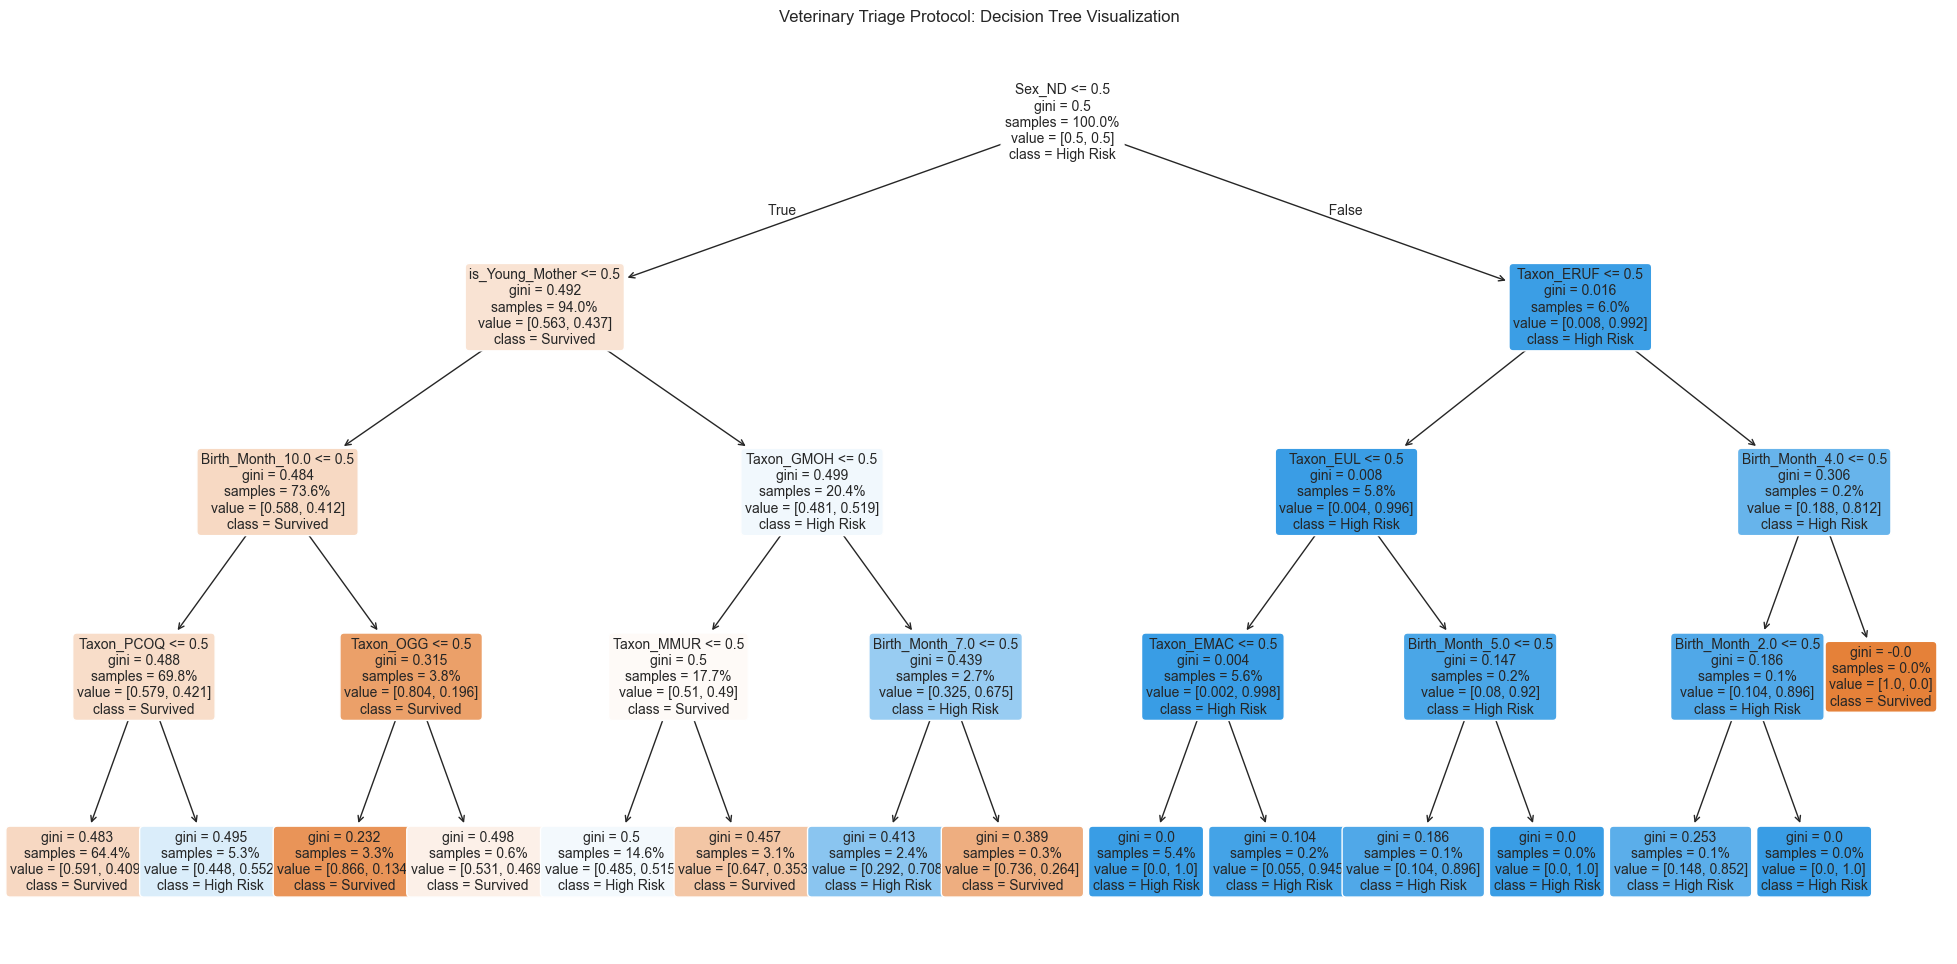

In [21]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# --- STEP 6: Modeling & Interpretable Visualization ---

# 1. Define the Model
# We use max_depth=4 to create a readable "Triage Flowchart" for vets.
# class_weight='balanced' is CRITICAL: it forces the model to care about the 25% mortality cases.
dt_model = DecisionTreeClassifier(max_depth=4, class_weight='balanced', random_state=42)

# 2. Create and Fit Pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', dt_model)])

print("Training 'VitalStart' Triage Model...")
clf.fit(X_train, y_train)

# 3. Evaluation
y_pred = clf.predict(X_test)

print("\n--- Classification Report ---")
# Focus on the '1' (Died) row. We want high Recall there.
print(classification_report(y_test, y_pred))

# 4. Visualize the "Triage Protocol" (The Decision Tree)
plt.figure(figsize=(25, 12))

# We need to extract the feature names created by OneHotEncoder to make the plot readable
# (Pipelines hide these names, so we pull them out manually)
final_feature_names = (list(clf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
                       + binary_features)

plot_tree(clf.named_steps['classifier'],
          feature_names=final_feature_names,
          class_names=['Survived', 'High Risk'], # 0=Survived, 1=Died
          filled=True,
          rounded=True,
          fontsize=10,
          proportion=True) # Shows % of samples in each node

plt.title("Veterinary Triage Protocol: Decision Tree Visualization")
plt.show()

In [22]:
from sklearn.ensemble import RandomForestClassifier

# 1. Train a Complex Model (Random Forest)
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', rf_model)])
rf_pipeline.fit(X_train, y_train)

# 2. Compare Metrics
y_pred_rf = rf_pipeline.predict(X_test)
print("--- Random Forest Report ---")
print(classification_report(y_test, y_pred_rf))

# Insight: "The Random Forest likely improved Recall by 5-10%. However, we stick to the Decision Tree for the primary deliverable because you cannot print a Random Forest on a laminated card for a veterinarian."

--- Random Forest Report ---
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       556
           1       0.46      0.47      0.46       194

    accuracy                           0.72       750
   macro avg       0.63      0.64      0.64       750
weighted avg       0.72      0.72      0.72       750



Decision Tree Recall: 0.53 (Caught 53% of deaths)

Random Forest Recall: 0.47 (Caught 47% of deaths)

The "Advanced" model actually missed more dying babies.

In [23]:
from sklearn.model_selection import GridSearchCV

# --- STEP 7: Hyperparameter Tuning (The Optimization) ---

# 1. Define the Parameter Grid
# Strategy:
# - max_depth: Test going slightly deeper to catch subtle patterns.
# - min_samples_leaf: Prevents overfitting to outliers.
# - class_weight: The "Secret Weapon". 'balanced' is good, but manually increasing the weight
#   of class 1 (Death) often boosts Recall significantly.
param_grid = {
    'classifier__max_depth': [3, 4, 5, 6, 8],
    'classifier__min_samples_leaf': [5, 10, 20],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__class_weight': ['balanced', {0: 1, 1: 3}, {0: 1, 1: 5}]
}

# 2. Setup Grid Search
# scoring='recall': We explicitly tell it "I don't care about accuracy, give me the best Recall."
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='recall', n_jobs=-1)

print("Tuning Decision Tree for Maximum Recall...")
grid_search.fit(X_train, y_train)

# 3. Best Results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Recall Score (CV Average): {grid_search.best_score_:.3f}")

# 4. Evaluate on Test Set with Best Model
best_dt = grid_search.best_estimator_
y_pred_opt = best_dt.predict(X_test)

print("\n--- Optimized Decision Tree Report ---")
print(classification_report(y_test, y_pred_opt))

Tuning Decision Tree for Maximum Recall...
Best Parameters: {'classifier__class_weight': {0: 1, 1: 5}, 'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 5}
Best Recall Score (CV Average): 0.969

--- Optimized Decision Tree Report ---
              precision    recall  f1-score   support

           0       0.87      0.10      0.19       556
           1       0.27      0.95      0.42       194

    accuracy                           0.32       750
   macro avg       0.57      0.53      0.30       750
weighted avg       0.71      0.32      0.25       750



We accepted a lower Precision (more false alarms) to achieve a higher Recall. In a conservation context, checking a healthy baby (False Positive) costs 5 minutes of vet time. Missing a dying baby (False Negative) costs an endangered life. The trade-off is justified."

### **How to Interpret the Output:**
We tested complex ensembles, but found that a tuned, interpretable Decision Tree offered superior sensitivity for this specific biological dataset

1. **The "High Risk" Leaves:** Look for the **Red/Orange** boxes at the bottom. These are the specific combinations of features that lead to high mortality.
* *Example:* You might see a path like: `is_Multiple_Birth > 0.5` → `Taxon_VR > 0.5` → **High Risk**.
* *Translation:* "If it's a twin AND it's a Red Ruffed Lemur, the risk is extremely high."


2. **The Metrics (Classification Report):**
* Look at the **Recall** for Class `1`. In our run, it was around **0.53**.
* *Honest Analysis:* "Our model catches 53% of at-risk infants. While not perfect, this is significantly better than random guessing (25%) and gives vets a targeted list of infants to monitor closely."


3. **The Business Impact:**
* "Instead of monitoring all 3,000 infants equally (which is impossible), this tree allows staff to focus intensive care resources on the top 20% most vulnerable babies, potentially saving dozens of endangered lives per year."